C:\Users\wzzha\AppData\Local\Temp\ipykernel_22372\3474876710.py:273: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs
c:\Users\wzzha\miniconda3\envs\futu_trends\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


       trend_length  direction                       end_date
count     42.000000  42.000000                             42
mean       7.547619   0.095238  2023-06-11 05:42:51.428571392
min        5.000000  -1.000000            2021-10-19 00:00:00
25%        5.250000  -1.000000            2022-08-29 06:00:00
50%        7.000000   1.000000            2023-05-21 00:00:00
75%        9.000000   1.000000            2024-04-08 06:00:00
max       14.000000   1.000000            2025-03-21 00:00:00
std        2.587044   1.007521                            NaN


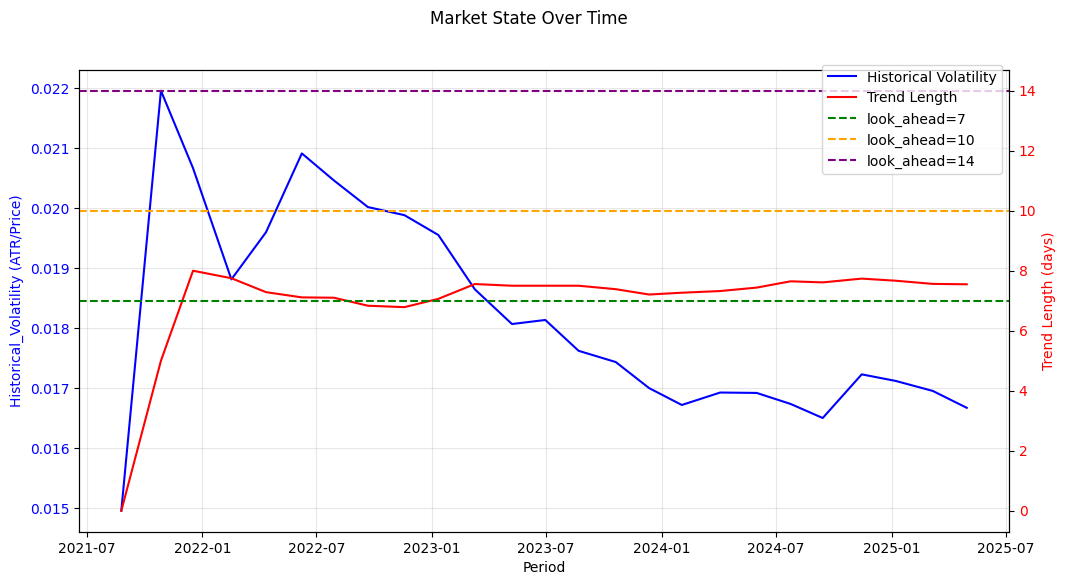

In [165]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from hyperopt import hp, fmin, tpe, Trials
from IPython.display import display
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram
import os

# 设置随机种子
random_seed = 42  # 可以选择任意整数（如 42、2025 等）
np.random.seed(random_seed)
random.seed(random_seed)

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_SH_510880_20250503_K_DAY.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# ATR计算（矢量化）
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=int(period), min_periods=1).mean()

# Numba加速未来范围计算
@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

def calculate_trend_duration(df, min_trend_days=5):
    """
    使用均线理论计算趋势长度，以趋势终结日期为索引
    
    参数:
    - min_trend_days: 最小趋势天数
    
    返回:
    - DataFrame包含趋势信息：trend_length, direction
    - 索引为趋势终结日期
    """
    # 计算均线
    df = df.copy()
    df['ma_short'] = df['close'].rolling(window=5).mean()
    df['ma_middle'] = df['close'].rolling(window=10).mean()
    df['ma_long'] = df['close'].rolling(window=15).mean()
    
    trends_data = []
    current_trend = {
        'direction': 0,  # 1: 上升, -1: 下降
        'days': 0,
    }
    
    for i in range(15, len(df)):
        today = df.index[i]
        # 判断趋势方向
        is_uptrend = (df['ma_short'].iloc[i] > df['ma_middle'].iloc[i] > df['ma_long'].iloc[i] and
                     df['ma_short'].iloc[i] > df['ma_short'].iloc[i-1])
        is_downtrend = (df['ma_short'].iloc[i] < df['ma_middle'].iloc[i] < df['ma_long'].iloc[i] and
                       df['ma_short'].iloc[i] < df['ma_short'].iloc[i-1])
        
        if current_trend['direction'] == 0:  # 新趋势开始
            if is_uptrend:
                current_trend = {
                    'direction': 1,
                    'days': 1,
                }
            elif is_downtrend:
                current_trend = {
                    'direction': -1,
                    'days': 1,
                }
        else:  # 已有趋势
            if (current_trend['direction'] == 1 and is_uptrend) or \
               (current_trend['direction'] == -1 and is_downtrend):
                # 趋势继续
                current_trend['days'] += 1
            else:
                # 趋势结束
                if current_trend['days'] >= min_trend_days:
                    trends_data.append({
                        'trend_length': current_trend['days'],
                        'direction': current_trend['direction'],
                        'end_date': today
                    })
                # 重置趋势
                current_trend = {
                    'direction': 0,
                    'days': 0,
                }
    
    # 转换为DataFrame，使用趋势终结日期作为索引
    trends_df = pd.DataFrame(trends_data, index=[trend['end_date'] for trend in trends_data])
    
    # 丢弃首尾趋势
    if len(trends_df) > 2:
        trends_df = trends_df.iloc[1:-1]
    
    return trends_df

# 按时间段分析市场状态
def analyze_market_states(df, period=21):
    df = df.copy()
    # df['date'] = df.index
    group_count = np.ceil(len(df) / period)
    grouped = np.array_split(df, group_count)
    
    volatility = []
    historical_volatility = []
    trend_length = []
    periods = []
    
    # 预先计算全局趋势
    trends_df = calculate_trend_duration(df)
    print(trends_df.describe())
    
    for i, group in enumerate(grouped):
        name = group.index[-1]
        atr = ATR(group['high'], group['low'], group['close'], period=period)
        vol = atr.mean() / group['close'].mean()
        volatility.append(vol)
        
        # 获取当前分组最后一天之前的所有趋势
        group_end = group.index[-1]
        historical_trends = trends_df[trends_df.index <= group_end]['trend_length'].values
        
        # 计算历史趋势长度中位数
        if len(historical_trends) > 0:
            trend_median = np.mean([f for f in historical_trends if f > 0])
            trend_length.append(trend_median)
        else:
            trend_length.append(0)

        historical_volatility.append(np.mean(volatility))
        periods.append(name)
    
    return pd.DataFrame({
        'Period': periods,
        'Volatility': volatility,
        'Historical_Volatility': historical_volatility,
        'Trend_Length': trend_length
    })

# 绘制状态图表
def plot_market_states(df_states):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 波动性（左轴）
    ax1.plot(df_states['Period'], df_states['Historical_Volatility'], color='blue', label='Historical Volatility')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Historical_Volatility (ATR/Price)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    
    # 趋势长度（右轴）
    ax2 = ax1.twinx()
    ax2.plot(df_states['Period'], df_states['Trend_Length'], color='red', label='Trend Length')
    ax2.set_ylabel('Trend Length (days)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 添加参考线
    ax2.axhline(7, color='green', linestyle='--', label='look_ahead=7')
    ax2.axhline(10, color='orange', linestyle='--', label='look_ahead=10')
    ax2.axhline(14, color='purple', linestyle='--', label='look_ahead=14')
    
    fig.suptitle('Market State Over Time')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# 趋势持续时间分布
def plot_trend_duration_distribution(df, smooth_window=5):
    if len(df) <= smooth_window:
        print('df length is less than smooth_window')
        return 0, 0

    trends = calculate_trend_duration(df, smooth_window)
    
    if len(trends) <= 1:
        print('trends length is less than 1')
        return 0, 0
    mean_duration = np.mean(trends['trend_length'].values) 
    median_duration = np.median(trends['trend_length'].values)

    plt.figure(figsize=(10, 6))
    plt.hist(trends['trend_length'], bins=30, color='blue', alpha=0.7, label='Trend Duration Distribution')
    plt.axvline(mean_duration, color='red', linestyle='--', label=f'Mean: {mean_duration:.1f} days')
    plt.axvline(median_duration, color='green', linestyle='--', label=f'Median: {median_duration:.1f} days')
    plt.title(f'Trend Duration Distribution (smooth_window={smooth_window})')
    plt.xlabel('Duration (days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return mean_duration, median_duration

def determine_look_ahead(volatility, trend_length):
    # look_ahead简洁参考规则
    # 规则 1：根据波动性和趋势长度选择 look_ahead
    # 高波动 + 短趋势（震荡行情）：
    # 波动性 > 0.03，且趋势长度 < 7 天。
    # 推荐 look_ahead：7 天。
    # 理由：捕捉快速顶底，信号密集，适合每周 2-3 次（每月 ≈ 10-15 次）。
    # 适用标的：高波动个股（如科技股）、震荡期指数。
    # 低波动 + 长趋势（趋势行情）：
    # 波动性 < 0.02，且趋势长度 > 10 天。
    # 推荐 look_ahead：14 天。
    # 理由：减少无效信号，确认趋势反转，信号频率降低（每月 ≈ 5-10 次）。
    # 适用标的：低波动指数（如蓝筹股指数）、趋势期市场。
    # 中等波动 + 中等趋势（混合行情）：
    # 波动性 0.02-0.03，或趋势长度 7-10 天。
    # 推荐 look_ahead：10 天。
    # 理由：平衡胜率和召回率，信号频率适中（每月 ≈ 7-12 次）。
    # 适用标的：中波动指数（如上证综指）、混合期市场。
    # 规则 2：调整信号频率
    # 如果信号频率过高（每月 > 15 次）：
    # 增加 strength_threshold（如 0.1 → 0.2），减少信号数量。
    # 或缩短 atr_period_explicit 和 atr_period_hidden（如 45 → 20），提高信号质量。
    # 如果信号频率过低（每月 < 5 次）：
    # 降低 strength_threshold（如 0.2 → 0.1），增加信号数量。
    # 或延长 look_ahead（如 7 → 10），捕捉更多反转。
    # 规则 3：通用性扩展
    # 高波动标的（个股或高风险资产）：
    # 默认波动性阈值可放宽（> 0.04 算高波动），趋势长度阈值缩短（< 5 天）。
    # 低波动标的（债券指数或稳定资产）：
    # 默认波动性阈值收紧（< 0.015 算低波动），趋势长度阈值延长（> 12 天）。
    # 调整范围：
    # 波动性范围：0.01-0.06（灵活调整）。
    # 趋势长度范围：3-20 天（根据分布调整）。
    if volatility > 0.03 and trend_length < 7:
        return 7
    elif volatility < 0.02 and trend_length > 10:
        return 14
    else:
        return 10

# 测试不同参数
# for smooth_window in [5, 10, 20, 30, 60]:
#     for min_return in [0]:
#         mean_duration, median_duration = plot_trend_duration_distribution(df, smooth_window)
#         print(f"smooth_window={smooth_window}, Mean={mean_duration:.1f}, Median={median_duration:.1f}")

def calculate_target_multiplier(df, atr_period=20, look_ahead=10):
    df = df.copy()
    atr = ATR(df['high'], df['low'], df['close'], period=atr_period)
    df['atr'] = atr
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    support_returns = (df['future_high'] - df['close']) / df['atr']
    resistance_returns = (df['close'] - df['future_low']) / df['atr']
    valid_returns = pd.concat([support_returns.dropna(), resistance_returns.dropna()])
    
    return np.median(valid_returns) if len(valid_returns) > 0 else 1.0

def calculate_atr_period(df, max_period=60):
    daily_range = df['high'] - df['low']
    freqs, power = periodogram(daily_range.dropna())
    periods = 1 / freqs
    valid_idx = np.where((periods > 5) & (periods <= max_period))
    dominant_period = periods[valid_idx][np.argmax(power[valid_idx])]
    return int(dominant_period) if dominant_period else 36

def get_signal_target_percentage(volatility):
    if volatility > 0.03:
        return 0.07  # 震荡行情，信号密集
    elif volatility < 0.02:
        return 0.03  # 趋势行情，信号稀疏
    else:
        return 0.05  # 混合行情，适中

# 随机指标计算（矢量化）
def Stochastic(high, low, close, k_period, d_period):
    low_min = low.rolling(window=int(k_period), min_periods=1).min()
    high_max = high.rolling(window=int(k_period), min_periods=1).max()
    k = 100 * (close - low_min) / (high_max - low_min)
    d = k.rolling(window=int(d_period), min_periods=1).mean()
    return k, d

# 主流atr_period
atr_period = calculate_atr_period(df)
# 分析市场状态
df_states = analyze_market_states(df, period=atr_period)
plot_market_states(df_states)
# 最近市场状态
current_state = df_states.iloc[-1]
currnet_look_ahead = determine_look_ahead(current_state['Historical_Volatility'], current_state['Trend_Length'])
look_ahead = currnet_look_ahead # 根据近期Trend Duration Distribution估计
target_multiplier = calculate_target_multiplier(df, atr_period=atr_period, look_ahead=look_ahead)

# 根据市场状态调整目标百分比
signal_target_percentage = get_signal_target_percentage(current_state['Historical_Volatility'])
signal_count_target = len(df) * signal_target_percentage

# 矢量化信号检测，区分显性和隐秘强信号
def detect_stochastic_signals_vectorized(df, k_period=14, d_period=3, overbought=55, oversold=45, support_ma_period=20, resistance_ma_period=20,atr_period_explicit=14, atr_period_hidden=14, strength_threshold=2, mode='train'):
    df = df.copy()
    k, d = Stochastic(df['high'], df['low'], df['close'], k_period, d_period)
    df['k'] = k
    df['d'] = d
    support_ma = df['close'].rolling(window=int(support_ma_period), min_periods=1).mean()
    resistance_ma = df['close'].rolling(window=int(resistance_ma_period), min_periods=1).mean()
    ma_short = df['close'].rolling(window=5).mean().fillna(0)
    ma_middle = df['close'].rolling(window=10).mean().fillna(0)
    ma_long = df['close'].rolling(window=15).mean().fillna(0)
    # vol_ma = df['volume'].rolling(window=5, min_periods=1).mean()
    atr_explicit = ATR(df['high'], df['low'], df['close'], period=atr_period_explicit)
    atr_hidden = ATR(df['high'], df['low'], df['close'], period=atr_period_hidden)
    
    df['signal_strength'] = abs(k - d)
    df['k_amplitude'] = df['high'] - df['low']

    support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & ((ma_short < ma_middle) & (ma_middle < ma_long)) & (df['close'] < support_ma)
    resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & ((ma_short > ma_middle) & (ma_middle > ma_long)) & (df['close'] > resistance_ma)

    if mode == 'eval':
        # 推理考虑未来阳线
        # support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & ((ma_short < ma_middle) & (ma_middle < ma_long)) & (df['close'] < support_ma) & ((df['close'].shift(-1) > df['close']) | (df['open'].shift(-1) < df['close'].shift(-1)))
        # resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & ((ma_short > ma_middle) & (ma_middle > ma_long)) & (df['close'] > resistance_ma) & ((df['close'].shift(-1) < df['close']) | (df['open'].shift(-1) > df['close'].shift(-1)))
        support_condition = support_condition & (((df['close'].shift(-1) > df['close'])&(df['open'].shift(-1) < df['close'].shift(-1))) | ((df['close'] < df['close'].shift(-2))&(df['close'].shift(-1) < df['close'].shift(-2))))
        resistance_condition = resistance_condition & (((df['close'].shift(-1) < df['close'])&(df['open'].shift(-1) > df['close'].shift(-1))) | ((df['close'] > df['close'].shift(-2))&(df['close'].shift(-1) > df['close'].shift(-2))))
    elif mode == 'train':
        # 训练无未来函数
        pass

    df['reversal'] = np.select(
        [support_condition, resistance_condition],
        ['support reversal', 'resistance reversal'],
        default='none'
    )
    
    # 显性强信号 放量突破
    df['is_strong_explicit'] = np.where(
        (df['reversal'] != 'none') &
        (df['k_amplitude'] > atr_explicit) & 
        (df['signal_strength'] >= strength_threshold),
        1, 0
    )
    
    # 隐秘强信号 小实体衰竭
    df['is_strong_hidden'] = np.where(
        (df['reversal'] != 'none') & 
        (df['k_amplitude'] < atr_hidden) &
        (df['signal_strength'] >= strength_threshold),
        # (df['volume'] < vol_ma),
        # (abs(df['close'] - ma) < atr_hidden),
        1, 0
    )
    
    df['is_strong'] = np.where(
        (df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1),
        1, 0
    )
    
    return df

def calculate_win_rate(df, look_ahead=10, target_multiplier=1, atr_period=20):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=atr_period)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)

    df['recent_high'] = df['high'].rolling(window=3, min_periods=1).max()
    df['recent_low'] = df['low'].rolling(window=3, min_periods=1).min()
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']) & (df['recent_low'] <= df['future_low']),
        1, 0
    )
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']) & (df['recent_high'] >= df['future_high']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong'] == 1)]
    strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong'] == 1)]
    strong_support_win_rate = strong_support_signals['support_win'].mean() if len(strong_support_signals) > 0 else 0
    strong_resistance_win_rate = strong_resistance_signals['resistance_win'].mean() if len(strong_resistance_signals) > 0 else 0
    
    explicit_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_support_win_rate = explicit_strong_support_signals['support_win'].mean() if len(explicit_strong_support_signals) > 0 else 0
    explicit_strong_resistance_win_rate = explicit_strong_resistance_signals['resistance_win'].mean() if len(explicit_strong_resistance_signals) > 0 else 0
    
    hidden_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_support_win_rate = hidden_strong_support_signals['support_win'].mean() if len(hidden_strong_support_signals) > 0 else 0
    hidden_strong_resistance_win_rate = hidden_strong_resistance_signals['resistance_win'].mean() if len(hidden_strong_resistance_signals) > 0 else 0
    
    support_recall = len(strong_support_signals) / len(support_signals) if len(support_signals) > 0 else 0
    resistance_recall = len(strong_resistance_signals) / len(resistance_signals) if len(resistance_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'strong_support_win_rate': strong_support_win_rate,
        'strong_support_signals_count': len(strong_support_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'strong_resistance_signals_count': len(strong_resistance_signals),
        'explicit_strong_support_win_rate': explicit_strong_support_win_rate,
        'explicit_strong_support_signals_count': len(explicit_strong_support_signals),
        'explicit_strong_resistance_win_rate': explicit_strong_resistance_win_rate,
        'explicit_strong_resistance_signals_count': len(explicit_strong_resistance_signals),
        'hidden_strong_support_win_rate': hidden_strong_support_win_rate,
        'hidden_strong_support_signals_count': len(hidden_strong_support_signals),
        'hidden_strong_resistance_win_rate': hidden_strong_resistance_win_rate,
        'hidden_strong_resistance_signals_count': len(hidden_strong_resistance_signals),
        'support_recall': support_recall,
        'resistance_recall': resistance_recall,
        'detailed_df': df
    }

# 参数空间
space = {
    'k_period': hp.quniform('k_period', 9, 21, 1),  #聚焦有效范围
    'd_period': hp.quniform('d_period', 3, 7, 1),
    'overbought': hp.quniform('overbought', 50, 90, 5),
    'oversold': hp.quniform('oversold', 10, 50, 5),
    'support_ma_period': hp.quniform('support_ma_period', 5, 60, 5),
    'resistance_ma_period': hp.quniform('resistance_ma_period', 5, 60, 5),
    'atr_period_explicit': hp.quniform('atr_period_explicit', 5, 60, 5),
    'atr_period_hidden': hp.quniform('atr_period_hidden', 5, 60, 5),
    'strength_threshold': hp.quniform('strength_threshold', 0.1, 2, 0.1)
}

# 目标函数，调整优化目标以保留更多信号
def objective(params):
    # 转换为整数值
    params_int = {
        'k_period': int(params['k_period']),
        'd_period': int(params['d_period']),
        'overbought': params['overbought'],
        'oversold': params['oversold'],
        'support_ma_period': int(params['support_ma_period']),
        'resistance_ma_period': int(params['resistance_ma_period']),
        'atr_period_explicit': int(params['atr_period_explicit']),
        'atr_period_hidden': int(params['atr_period_hidden']),
        'strength_threshold': params['strength_threshold']
    }
    df_with_signals = detect_stochastic_signals_vectorized(df.copy(), mode='train',**params_int)
    result = calculate_win_rate(df_with_signals, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)
    
    # 计算F2得分（β=2，更重视召回率）
    # beta = 2
    # support_precision = result['strong_support_win_rate']
    # support_recall = result['support_recall']
    # resistance_precision = result['strong_resistance_win_rate']
    # resistance_recall = result['resistance_recall']
    
    # support_f2 = (1 + beta**2) * (support_precision * support_recall) / (beta**2 * support_precision + support_recall) if (support_precision + support_recall) > 0 else 0
    # resistance_f2 = (1 + beta**2) * (resistance_precision * resistance_recall) / (beta**2 * resistance_precision + resistance_recall) if (resistance_precision + resistance_recall) > 0 else 0
    # score = (support_f2 + resistance_f2) / 2

    support_f1 = 2 * (result['strong_support_win_rate'] * result['support_recall']) / (result['strong_support_win_rate'] + result['support_recall']) if (result['strong_support_win_rate'] + result['support_recall']) > 0 else 0
    resistance_f1 = 2 * (result['strong_resistance_win_rate'] * result['resistance_recall']) / (result['strong_resistance_win_rate'] + result['resistance_recall']) if (result['strong_resistance_win_rate'] + result['resistance_recall']) > 0 else 0
    score = (support_f1 + resistance_f1) / 2
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(1.0, min(result['strong_support_signals_count'], result['strong_resistance_signals_count']) / signal_count_target)
    adjusted_score = score * signal_count_penalty
    
    return -adjusted_score  # 负值用于最小化

def plot_signals(result, name=''):
    df_visual = result['detailed_df']
    plt.figure(figsize=(16, 8))
    plt.plot(df_visual.index, df_visual['close'], label='Close Price', color='blue', alpha=0.5)

    # 显性强信号
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='o', label='Explicit Strong Support (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='o', label='Explicit Strong Support (Lose)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='s', label='Explicit Strong Resistance (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='s', label='Explicit Strong Resistance (Lose)', s=100)

    # 隐秘强信号（用不同标记区分）
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='^', label='Hidden Strong Support (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='^', label='Hidden Strong Support (Lose)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='v', label='Hidden Strong Resistance (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='v', label='Hidden Strong Resistance (Lose)', s=100)

    # 弱信号（淡化显示）
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='o', label='Weak Support (Win)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='o', label='Weak Support (Lose)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='s', label='Weak Resistance (Win)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='s', label='Weak Resistance (Lose)', s=30, alpha=0.3)

    # 增强标题信息
    title = (
        f'{name} Stochastic Oscillator Signals\n'
        # f'k={best_params["k_period"]}, d={best_params["d_period"]}, overbought={best_params["overbought"]}, oversold={best_params["oversold"]}, support_ma={best_params["support_ma_period"]}, resistance_ma={best_params["resistance_ma_period"]}, atr_explicit={best_params["atr_period_explicit"]}, atr_hidden={best_params["atr_period_hidden"]}, threshold={best_params["strength_threshold"]:.1f}\n'
        # f'k={best_params["k_period"]}, d={best_params["d_period"]}, overbought={best_params["overbought"]}, oversold={best_params["oversold"]}, atr_explicit={best_params["atr_period_explicit"]}, atr_hidden={best_params["atr_period_hidden"]}, threshold={best_params["strength_threshold"]:.1f}\n'
        # f'k={best_params["k_period"]}, d={best_params["d_period"]}, overbought={best_params["overbought"]}, oversold={best_params["oversold"]}, threshold={best_params["strength_threshold"]:.1f}\n'
        f'Explicit Strong Support Win Rate: {result["explicit_strong_support_win_rate"]:.2%} (Signals: {result["explicit_strong_support_signals_count"]})\n'
        f'Explicit Strong Resistance Win Rate: {result["explicit_strong_resistance_win_rate"]:.2%} (Signals: {result["explicit_strong_resistance_signals_count"]})\n'
        f'Hidden Strong Support Win Rate: {result["hidden_strong_support_win_rate"]:.2%} (Signals: {result["hidden_strong_support_signals_count"]})\n'
        f'Hidden Strong Resistance Win Rate: {result["hidden_strong_resistance_win_rate"]:.2%} (Signals: {result["hidden_strong_resistance_signals_count"]})\n'
        f'Support Win Rate: {result["support_win_rate"]:.2%}\n'
        f'Resistance Win Rate: {result["resistance_win_rate"]:.2%}\n'
        f'Support Recall: {result["support_recall"]:.2%}\n'
        f'Resistance Recall: {result["resistance_recall"]:.2%}'
    )
    plt.title(title, fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.show()

# 显示尾部行
# print("\nDetailed DataFrame (Last Rows):")
# display(result['detailed_df'][['open', 'high', 'low', 'close', 'volume', 'reversal', 'signal_strength', 'is_strong', 'is_strong_explicit', 'is_strong_hidden', 'support_target', 'resistance_target', 'future_high', 'future_low', 'support_win', 'resistance_win']].tail(20))

# 可视化自相关
# acf_values = acf(df['close'].dropna(), nlags=120, fft=True)
# plt.plot(acf_values, label='ACF')
# plt.axhline(0.1, color='r', linestyle='--', label='Threshold 0.1')
# plt.title('Autocorrelation Function')
# plt.xlabel('Lag (days)')
# plt.ylabel('Correlation')
# plt.legend()
# plt.show()

# 可视化反转幅度
# atr = ATR(df['high'], df['low'], df['close'], period=20)
# support_returns = (result['detailed_df']['future_high'] - df['close']) / atr
# resistance_returns = (df['close'] - result['detailed_df']['future_low']) / atr
# plt.hist(support_returns.dropna(), bins=50, alpha=0.5, label='Support Returns')
# plt.hist(resistance_returns.dropna(), bins=50, alpha=0.5, label='Resistance Returns')
# plt.axvline(np.median(pd.concat([support_returns.dropna(), resistance_returns.dropna()])), color='r', label='Median')
# plt.title('Historical Reversal Multipliers')
# plt.xlabel('Multiplier (relative to ATR)')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# 可视化周期图
# freqs, power = periodogram(df['high'] - df['low'])
# 过滤掉零频率
# valid_freqs = np.where(freqs == 0, 1, freqs)
# periods = 1 / valid_freqs
# plt.plot(periods, power)
# plt.xlim(5, 60)
# # plt.ylim(-1000, 50000)
# plt.title('Periodogram of Daily Range')
# plt.xlabel('Period (days)')
# plt.ylabel('Power')
# plt.show()

Train

In [166]:
# 执行贝叶斯优化
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=500, trials=trials)

100%|██████████| 500/500 [00:35<00:00, 14.18trial/s, best loss: -0.6934011026878015]


Checked signals

Support Reversal for data_SH_510880_20250503_K_DAY.csv:
Current Market State: 2025-04-30 00:00:00
Current Market State Volatility: 0.01667099295977069
Current Market signal target percentage: 3.0%
Recommended look_ahead for 2025-04-30 00:00:00: 10 days
Pre-calculated: look_ahead=10, target_multiplier=1.29, atr_period=38
Best Parameters: {'k_period': 14, 'd_period': 7, 'overbought': 50.0, 'oversold': 45.0, 'support_ma_period': 50, 'resistance_ma_period': 60, 'atr_period_explicit': 50, 'atr_period_hidden': 60, 'strength_threshold': 0.1}
Overall Support Reversal Win Rate: 78.26% (Signals: 23)
Overall Resistance Reversal Win Rate: 58.06% (Signals: 31)
Strong Support Reversal Win Rate: 78.26% (Signals: 23)
Strong Resistance Reversal Win Rate: 62.07% (Signals: 29)
Explicit Strong Support Win Rate: 100.00% (Signals: 8)
Explicit Strong Resistance Win Rate: 73.33% (Signals: 15)
Hidden Strong Support Win Rate: 66.67% (Signals: 15)
Hidden Strong Resistance Win Rate: 50.00% (Signals: 16)
Support R

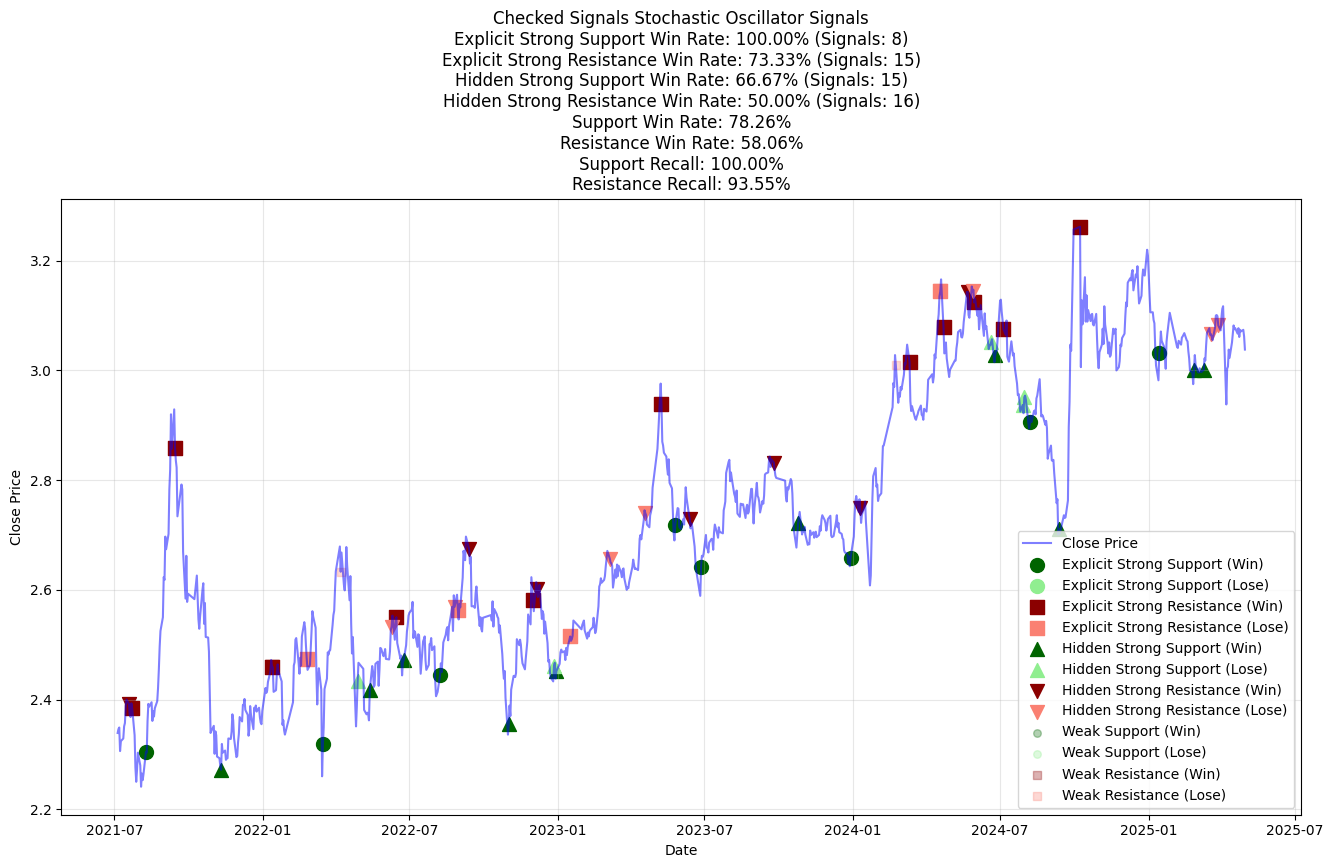

In [167]:
# 将best参数转换为实际值
best_params = {
    'k_period': int(best['k_period']),
    'd_period': int(best['d_period']),
    'overbought': best['overbought'],
    'oversold': best['oversold'],
    'support_ma_period': int(best['support_ma_period']),
    'resistance_ma_period': int(best['resistance_ma_period']),
    'atr_period_explicit': int(best['atr_period_explicit']),
    'atr_period_hidden': int(best['atr_period_hidden']),
    'strength_threshold': best['strength_threshold']
}

# 使用最佳参数计算最终信号
df = detect_stochastic_signals_vectorized(df,mode='eval', **best_params)
result = calculate_win_rate(df)

# 输出结果
# display(df_states.tail(12))
print(f"Support Reversal for {csv_filename}:")
print(f"Current Market State: {current_state['Period']}")
print(f"Current Market State Volatility: {current_state['Historical_Volatility']}")
print(f"Current Market signal target percentage: {signal_target_percentage*100}%")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result['support_win_rate']:.2%} (Signals: {result['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result['resistance_win_rate']:.2%} (Signals: {result['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result['strong_support_win_rate']:.2%} (Signals: {result['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result['strong_resistance_win_rate']:.2%} (Signals: {result['strong_resistance_signals_count']})")
print(f"Explicit Strong Support Win Rate: {result['explicit_strong_support_win_rate']:.2%} (Signals: {result['explicit_strong_support_signals_count']})")
print(f"Explicit Strong Resistance Win Rate: {result['explicit_strong_resistance_win_rate']:.2%} (Signals: {result['explicit_strong_resistance_signals_count']})")
print(f"Hidden Strong Support Win Rate: {result['hidden_strong_support_win_rate']:.2%} (Signals: {result['hidden_strong_support_signals_count']})")
print(f"Hidden Strong Resistance Win Rate: {result['hidden_strong_resistance_win_rate']:.2%} (Signals: {result['hidden_strong_resistance_signals_count']})")
print(f"Support Recall: {result['support_recall']:.2%}")
print(f"Resistance Recall: {result['resistance_recall']:.2%}")


plot_signals(result,'Checked Signals')

Origin Signals

Support Reversal for orignal data_SH_510880_20250503_K_DAY.csv:
Current Market State: 2025-04-30 00:00:00
Current Market State Volatility: 0.009915148337945923
Current Market signal target percentage: 3.0%
Recommended look_ahead for 2025-04-30 00:00:00: 10 days
Pre-calculated: look_ahead=10, target_multiplier=1.29, atr_period=38
Best Parameters: {'k_period': 14, 'd_period': 7, 'overbought': 50.0, 'oversold': 45.0, 'support_ma_period': 50, 'resistance_ma_period': 60, 'atr_period_explicit': 50, 'atr_period_hidden': 60, 'strength_threshold': 0.1}
Overall Support Reversal Win Rate: 70.00% (Signals: 30)
Overall Resistance Reversal Win Rate: 47.83% (Signals: 46)
Strong Support Reversal Win Rate: 70.00% (Signals: 30)
Strong Resistance Reversal Win Rate: 50.00% (Signals: 44)
Explicit Strong Support Win Rate: 90.91% (Signals: 11)
Explicit Strong Resistance Win Rate: 58.33% (Signals: 24)
Hidden Strong Support Win Rate: 57.89% (Signals: 19)
Hidden Strong Resistance Win Rate: 40.91% (Signals: 22)


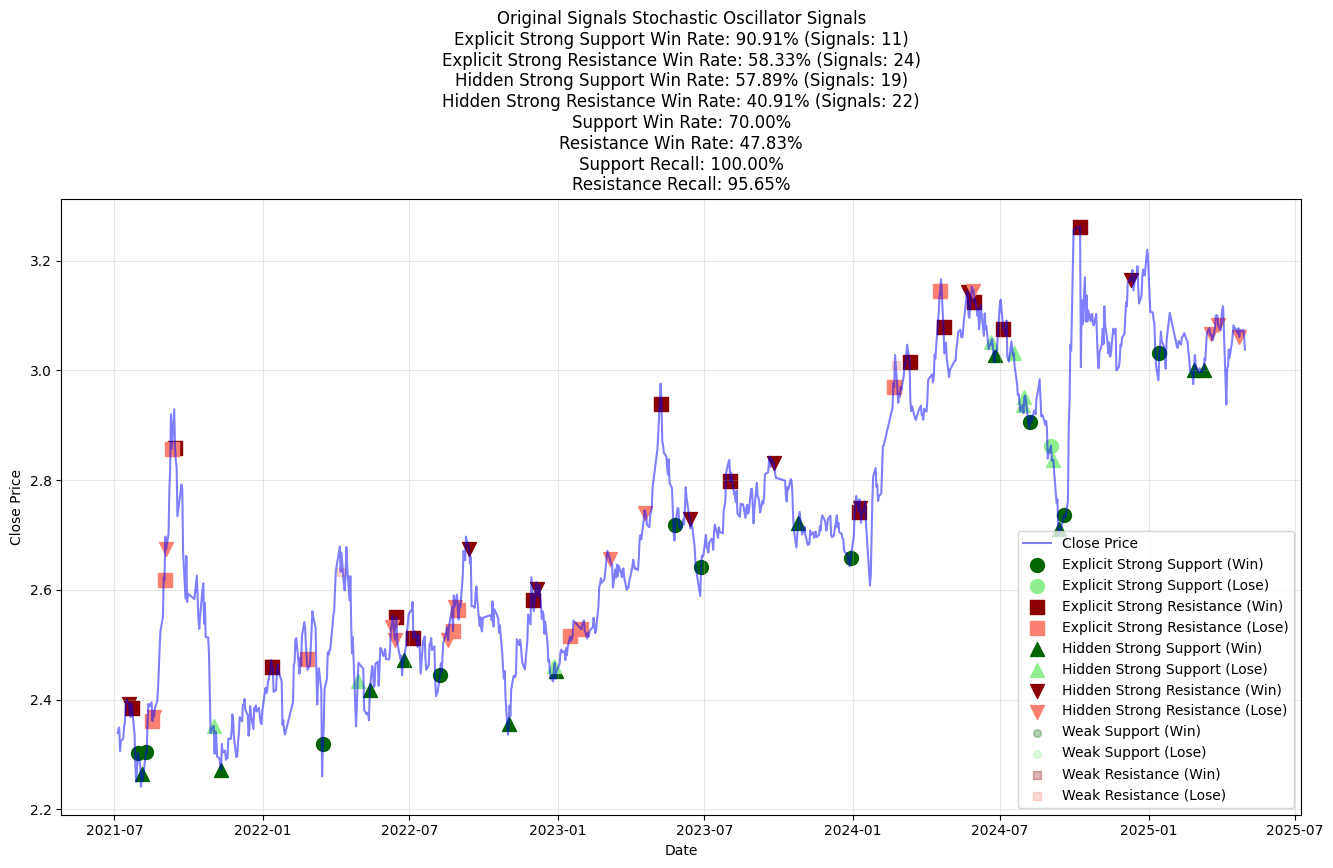

In [168]:
# 使用最佳参数计算最终信号
df_original = detect_stochastic_signals_vectorized(df,mode='train', **best_params)
result_original = calculate_win_rate(df_original)

# 输出结果
# display(df_states.tail(12))
print(f"Support Reversal for orignal {csv_filename}:")
print(f"Current Market State: {current_state['Period']}")
print(f"Current Market State Volatility: {current_state['Volatility']}")
print(f"Current Market signal target percentage: {signal_target_percentage*100}%")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result_original['support_win_rate']:.2%} (Signals: {result_original['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result_original['resistance_win_rate']:.2%} (Signals: {result_original['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result_original['strong_support_win_rate']:.2%} (Signals: {result_original['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result_original['strong_resistance_win_rate']:.2%} (Signals: {result_original['strong_resistance_signals_count']})")
print(f"Explicit Strong Support Win Rate: {result_original['explicit_strong_support_win_rate']:.2%} (Signals: {result_original['explicit_strong_support_signals_count']})")
print(f"Explicit Strong Resistance Win Rate: {result_original['explicit_strong_resistance_win_rate']:.2%} (Signals: {result_original['explicit_strong_resistance_signals_count']})")
print(f"Hidden Strong Support Win Rate: {result_original['hidden_strong_support_win_rate']:.2%} (Signals: {result_original['hidden_strong_support_signals_count']})")
print(f"Hidden Strong Resistance Win Rate: {result_original['hidden_strong_resistance_win_rate']:.2%} (Signals: {result_original['hidden_strong_resistance_signals_count']})")
print(f"Support Recall: {result_original['support_recall']:.2%}")
print(f"Resistance Recall: {result_original['resistance_recall']:.2%}")
plot_signals(result_original,'Original Signals')

In [169]:
# 将原始DataFrame保存为CSV文件
# csv_path = '../data/stochastic_signals_optimized.csv'
# result_original['detailed_df'].to_csv(csv_path, index=True)
# print(f"\nDetailed DataFrame saved to: {csv_path}")